In [1]:
import sys
# setting path
sys.path.append('../')

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import copy
from argparse import ArgumentParser

from Benchmarks.Models.BenchmarkCaller import *
from Utilities.Utilities import ReadYaml, SerializeObjects, DeserializeObjects, LoadModelConfigs, LoadParams
from tqdm import trange, tqdm
import itertools
from scipy.stats import mode


## GPU selection
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "4"

# TensorFlow wizardry
config = tf.compat.v1.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 1.0
# Create a session with the above options specified.
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))         

In [10]:
def CompResource (PredModel, Data, BatchSize=1, GPU=True):  # GPU vs CPU

    if GPU==False:
        with tf.device('/CPU:0'):
            PredVal = PredModel.predict(Data, batch_size=BatchSize, verbose=1)
    else:
        PredVal = PredModel.predict(Data, batch_size=BatchSize, verbose=1)

    return PredVal

# Power spectral density 
def FFT_PSD (Data, ReducedAxis, MinFreq = 1, MaxFreq = 51):
    # Dimension check; this part operates with 3D tensors.
    # (NMiniBat, NGen, SigDim)
    Data = Data[:,None] if len(Data.shape) < 3 else Data

    # Power Spectral Density
    HalfLen = Data.shape[-1]//2
    FFTRes = np.abs(np.fft.fft(Data, axis=-1)[..., :HalfLen])[..., MinFreq:MaxFreq]
    # (NMiniBat, NGen, N_frequency)
    PSD = (FFTRes**2)/Data.shape[-1]

    # Probability Density Function
    if ReducedAxis == 'All':
        AggPSD = np.mean(PSD, axis=(0,1))
        # (N_frequency,)
        AggPSPDF = AggPSD / np.sum(AggPSD, axis=(-1),keepdims=True)
    
    elif ReducedAxis =='Sample':
        AggPSD = np.mean(PSD, axis=(1))
        # (NMiniBat, N_frequency)
        AggPSPDF = AggPSD / np.sum(AggPSD, axis=(-1),keepdims=True)
    
    elif ReducedAxis == 'None':
        # (NMiniBat, NGen, N_frequency)
        AggPSPDF = PSD / np.sum(PSD, axis=(-1),keepdims=True)    
        
    return AggPSPDF


# Permutation given PSD over each generation
def ProbPermutation(Data, WindowSize=3):
    # For the M generation vectors, Data shape: (NMiniBat, N_frequency, NGen)
    # For the true PSD, Data shape: (1, N_frequency, NMiniBat)
    
    # Generating true permutation cases
    TruePerms = np.concatenate(list(itertools.permutations(np.arange(WindowSize)))).reshape(-1, WindowSize)

    # Getting all permutation cases
    Data_Ext = tf.signal.frame(Data, frame_length=WindowSize, frame_step=1, axis=-1)
    PermsTable =  np.argsort(Data_Ext, axis=-1)

    CountPerms = 1- (TruePerms[None,None,None] == PermsTable[:,:,:, None])
    CountPerms = 1-np.sum(CountPerms, axis=-1).astype('bool')
    # Reducing the window axis
    CountPerms = np.sum(CountPerms, axis=(2))
    
    # Data shape: (NMiniBat, N_frequency, N_permutation_cases)
    ProbCountPerms = CountPerms / np.sum(CountPerms, axis=-1, keepdims=True)
    
    return np.maximum(ProbCountPerms, 1e-7)    



def MeanKLD(P,Q):
    return np.mean(np.sum(P*np.log(P/Q), axis=-1))



def Sampler (Data, SampModel,BatchSize=100, GPU=True):
    if GPU==False:
        with tf.device('/CPU:0'):
            PredVal = SampModel.predict(Data, batch_size=BatchSize, verbose=1)   
    else:
        PredVal = SampModel.predict(Data, batch_size=BatchSize, verbose=1)   

    return PredVal



def SamplingZ (Data, SampModel, NMiniBat, NGen, BatchSize = 1000, GPU=True, SampZType='GaussBRpt', SecDataType=None, ReparaStdZj=1.):
    
    '''
    Sampling Samp_Z 

    - Shape of UniqSamp_Z: (NMiniBat, LatDim)
    - UniqSamp_Z ~ N(Zμ|y, σ) or N(Zμ|y, cond, σ) for Type =='Model*'
    - UniqSamp_Z ~ N(Zμ|y, cond, σ) for Type =='Model*' and when there are ancillary (i.e., Conditional VAE) data inputs 
    - RandSamp_Z ~ N(0, ReparaStdZj) for Type =='Gauss*'

    - Samp_Z is a 3D tensor expanded by repeating the first axis (i.e., 0) of UniqSamp_Z or RandSamp_Z by NGen times.
    - Shape of Samp_Z: (NMiniBat, NGen, LatDim) -> (NMiniBat*NGen, LatDim) for optimal use of GPU 
    
    - ModelBRpt:  The predicted values are repeated NGen times after the prediction. 
                  It is strongly recommended in cases where there are variations in the ancillary data inputs.  
    - ModelARand: The data is repeated NGen times before the prediction (i.e., All random sampling).
                  It is strongly recommended when there is no ancillary data inputs or variations in the ancillary data.     
    - Gauss:      The data is sampled NMiniBat*NGen times. 
                  It is recommended to detect the influence of changes in the value of j on the performance metrics, 
                  when the same ancillary data input is repeated NGen times (i.e., for Conditional VAE).
    - GaussBRpt:  The data sampled from the Gaussian distribution is repeated NGen times.
                  It is recommended for both cases: when there are no ancillary data inputs and when there is ancillary data input.
                  
    '''
    assert SampZType in ['ModelBRpt','ModelARand','Gauss', 'GaussBRpt'], "Please verify the value of 'SampZType'. Only 'ModelBRpt','ModelARand','Gauss', 'GaussBRpt' are valid."
    
    # Sampling Samp_Z
    if SampZType =='ModelBRpt': # Z ~ N(Zμ|y, σ) or N(Zμ|y, cond, σ) 
        UniqSamp_Z = Sampler(Data, SampModel, GPU=GPU)
        Samp_Z =  np.broadcast_to(UniqSamp_Z[:, None], (NMiniBat, NGen, UniqSamp_Z.shape[-1])).reshape(-1, UniqSamp_Z.shape[-1])
    
    elif SampZType =='ModelARand': # Z ~ N(Zμ|y, σ) or N(Zμ|y, cond, σ)
        
        if SecDataType == 'CONDIN' : # For the CondVAE
            DataRpt = [np.repeat(arr, NGen, axis=0) for arr in Data]
        else:
            DataRpt = np.repeat(Data, NGen, axis=0)
        Samp_Z = Sampler(DataRpt, SampModel, GPU=GPU)
        
    elif SampZType =='Gauss': # Z ~ N(0, ReparaStdZj)
        Samp_Z = np.random.normal(0, ReparaStdZj, (NMiniBat*NGen , SampModel.output.shape[-1]))
        
    elif SampZType =='GaussBRpt': # Z ~ N(0, ReparaStdZj)
        UniqSamp_Z = np.random.normal(0, ReparaStdZj, (NMiniBat , SampModel.output.shape[-1]))
        Samp_Z = np.repeat(UniqSamp_Z, NGen, axis=0)
    
    return Samp_Z



def SamplingZj (Samp_Z, NMiniBat, NGen, LatDim, NSelZ, ZjType='ARand' ):
    
    '''
     Sampling Samp_Zj 

    - Masking is applied to select Samp_Zj from Samp_Z 
      by assuming that the Samp_Z with indices other than j have a fixed mean value of '0' following a Gaussian distribution.

    - Shape of Samp_Zj: (NMiniBat, NGen, LatDim) -> (NMiniBat*NGen, LatDim) for optimal use of GPU 

    - Samp_Zj ~ N(Zμj|y, σj), j∼U(1,LatDim)
    - In the expression j∼U(1,LatDim), j corresponds to LatDim and all js are selected randomly.

    '''
    
    # Masking for selecting Samp_Zj from Samp_Z 
    if ZjType =='ARand': # All random masking
        Mask_Z = np.zeros((NMiniBat*NGen, LatDim))
        for i in range(NMiniBat*NGen):
            Mask_Z[i, np.random.choice(LatDim, NSelZ,replace=False )] = 1
            
    elif ZjType =='BRpt': # Random masking at the batch-sample level
        Mask_Z = np.zeros((NMiniBat, NGen, LatDim))
        for i in range(NMiniBat):
            Mask_Z[i, :, np.random.choice(LatDim, NSelZ,replace=False )] = 1
    
    # Selecting Samp_Zj from Samp_Z 
    Mask_Z = Mask_Z.reshape(NMiniBat*NGen, LatDim)
    Samp_Zj = Samp_Z * Mask_Z
    
    return Samp_Zj



def SamplingFCs (NMiniBat, NGen, NFCs, FCexist=None, SampFCType='ARand', FcLimit= 0.05):

    # Check for valid SampFCType values
    if SampFCType not in ['ARand', 'BRpt', 'Sort']:
        raise ValueError(f"Invalid SampFCType: {SampFCType}. Expected one of: 'ARand', 'BRpt', 'Sort'")
    
    # Sampling FCs
    ## Return shape of FCs: (NMiniBat*NGen, NFCs) instead of (NMiniBat, NGen, NFCs) for optimal use of GPU
    if SampFCType =='ARand':
        FCs = np.random.rand(NMiniBat*NGen, NFCs) * FcLimit
    elif SampFCType == 'BRpt' :
        FCs = np.random.rand(NMiniBat,  NFCs) * FcLimit
        FCs = np.repeat(FCs, NGen, axis=0)

    # For Sampling FC_organized 
    ## Return shape of FCs:(NMiniBat, NGen, NFCs) instead of (NMiniBat*NGen, NFCs)
    if FCexist is None:
        FCexist = FCs
        FCexist = FCexist.reshape(NMiniBat, NGen, NFCs)

    
    # Sampling FC_organized (i.e., FCor)
    if SampFCType == 'Sort' :
        FCs =np.sort(FCexist, axis=0).reshape(NMiniBat*NGen, NFCs)

    return FCs
    


In [11]:
YamlPath = './Config/EvalConfigART.yml'
ModelConfigs = ReadYaml(YamlPath)
[i for i in ModelConfigs]

['Common_Info',
 'BaseVAE_ART_30',
 'BaseVAE_ART_50',
 'FACVAE_ART_30',
 'FACVAE_ART_50',
 'ConVAE_ART_30',
 'ConVAE_ART_50',
 'TCVAE_ART_30',
 'TCVAE_ART_50']

In [12]:
ConfigName = 'BaseVAE_ART_50'
YamlPath = './Config/EvalConfigART.yml'
EvalConfigs = ReadYaml(YamlPath)

# Loading the model configurations
ModelConfigSet, ModelLoadPath = LoadModelConfigs(ConfigName, Comp=False)

# Loading parameters for the evaluation
Params = LoadParams(ModelConfigSet, EvalConfigs[ConfigName])
Params['Common_Info'] = EvalConfigs['Common_Info']


# Object Load path
ObjLoadPath = './EvalResults/Instances/Obj_'+ConfigName+'.pkl'
SampZjLoadPath = './Data/IntermediateData/'+ConfigName+'_SampZj_'+str(Params['NSelZ'])+'.npy'


In [13]:
# Loading data
TrData = np.load('../Data/ProcessedData/Tr'+str(Params['SigType'])+'.npy').astype('float32')
VallData = np.load('../Data/ProcessedData/Val'+str(Params['SigType'])+'.npy').astype('float32')

# Intermediate parameters 
SigDim = VallData.shape[1]
DataSize = VallData.shape[0]

In [14]:
# Calling Modesl
BenchModel, _, AnalData = ModelCall (ModelConfigSet, ConfigName, TrData, VallData, LoadWeight=True,  
                                         Reparam=True, ReparaStd=Params['ReparaStd'], ModelSaveName=ModelLoadPath) 


## The generation model for evaluation
GenModel = BenchModel.get_layer('ReconModel')

## The sampling model for evaluation
Inp_Enc = BenchModel.get_layer('Inp_Enc')
Zs = BenchModel.get_layer('Zs').output

if Params['SecDataType'] == 'CON':
    Inp_Cond = BenchModel.get_layer('Inp_Cond')
    SampModel = Model([Inp_Enc.input, Inp_Cond.input], Zs)
else:
    SampModel = Model(Inp_Enc.input, Zs)

ReconOutLoss added
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inp_Enc (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 tf.signal.frame_1 (TFOpLambda)  (None, 20, 50)      0           ['Inp_Enc[0][0]']                
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 20, 50)      11550       ['tf.signal.frame_1[0][0]']      
 )                                                                                                
                                                                                                  
 bidirectional_7 (Bidirectional  (None, 20, 50)      11550       ['bidire

In [15]:
class Evaluator ():
    
    def __init__ (self, MinFreq=1, MaxFreq=51,  SimSize = 1, NMiniBat=100,  NGen=100, ReparaStdZj = 1, NSelZ = 1, 
                  SampBatchSize = 1000, GenBatchSize = 1000, SelMetricCut = 1., SelMetricType = 'KLD', GPU=True):

        
        # Optional parameters with default values
        self.MinFreq = MinFreq               # The minimum frequency value within the analysis range (default = 1).
        self.MaxFreq = MaxFreq               # The maximum frequency value within the analysis range (default = 51).
        self.SimSize = SimSize               # Then umber of simulation repetitions for aggregating metrics (default: 1)
        self.NMiniBat = NMiniBat             # The size of the mini-batch, splitting the task into N pieces of size NMiniBat.
        self.NGen = NGen                     # The number of generations (i.e., samplings) within the mini-batch.
        self.ReparaStdZj = ReparaStdZj       # The size of the standard deviation when sampling Zj (Samp_Zjb ~ N(0, ReparaStdZj)).
        self.NSelZ = NSelZ                   # The size of js to be selected at the same time (default: 1).
        self.SampBatchSize = SampBatchSize   # The batch size during prediction of the sampling model.
        self.GenBatchSize= GenBatchSize      # The batch size during prediction of the generation model.
        self.GPU = GPU                       # GPU vs CPU during model predictions (i.e., for SampModel and GenModel).
        self.SelMetricCut = SelMetricCut           # The threshold for Zs and ancillary data where the metric value is below SelMetricCut.
        self.SelMetricType = SelMetricType         # The type of metric used for selecting Zs and ancillary data. 

    
    
    ''' ------------------------------------------------------ Ancillary Functions ------------------------------------------------------'''

    ### ----------- Searching for candidate Zj for plausible signal generation ----------- ###
    def LocCandZsMaxFreq (self, CandQV, Samp_Z, SecData=None):
        # Shape of CandQV: (NMiniBat x NGen, )
        # Shape of Samp_Z: (NMiniBat x NGen, LatDim)
        # Shape of SecData: (NMiniBat x NGen, SecDataDim)

        
        if self.SelMetricType == 'Entropy': 
            # Calculating the entropies given the probability density function of the power spectral.
            ## Return shape: (NMiniBat x NGen )
            Score = -np.sum(CandQV * np.log(CandQV), axis=1).ravel()
    
        elif self.SelMetricType == 'KLD':
            # Calculating KLD(QV_Batch||CandQV_T) (KLD_BatGen) and selecing IDs for which KLD_BatGen less than SelMetricCut.
            ## Shape of CandQV_T: (NMiniBat, N_frequency, NGen) -> (NMiniBat x NGen, N_frequency, 1), Shape of QV_Batch: (1, N_frequency, NMiniBat)
            CandQV_T = CandQV.transpose(0,2,1).reshape(self.NMiniBat*self.NGen, -1)[:,:,None]
            KLD_BatGen = np.sum(self.QV_Batch * np.log(self.QV_Batch / CandQV_T ), axis=1)
        
            ## Return shape: (NMiniBat x NGen )
            Score = np.min(KLD_BatGen, axis=-1)

        
        # Getting the maximum frequency given the PSD from CandQV.
        ## The 0 frequency is excluded as it represents the constant term; by adding 1 to the index, the frequency and index can be aligned to be the same.
        ## Return shape: (NMiniBat, NGen) -> (NMiniBat x NGen) for the computational efficiency (i.e, ravel function applied)
        MaxFreq = np.argmax(CandQV, axis=1).ravel() + 1

        for Freq, _ in self.BestZsMetrics.items():
            FreqIdx = np.where(MaxFreq == Freq)[0]

            # Skipping the remainder of the code if there are no FreqIdx present at the predefined frequencies.
            if len(FreqIdx) <1: 
                continue;

            # Calculating the minimum of Score and selecting candidate Z-values(CandZs)
            MinScoreIdx = np.argmin(Score[FreqIdx]) 
            MinScore = np.min(Score[FreqIdx]) 
            CandZs = Samp_Z[[FreqIdx[MinScoreIdx]]]
            
            # Tracking results
            self.TrackerCand_Temp[Freq]['TrackZs'].append(CandZs[None])
            self.TrackerCand_Temp[Freq]['TrackMetrics'].append(MinScore[None])
            
            if SecData is not None: # for processing secondary data (SecData).
                CandSecData = SecData[[FreqIdx[MinScoreIdx]]]
                self.TrackerCand_Temp[Freq]['TrackSecData'].append(CandSecData[None])
            else:
                CandSecData = None

            # Updating the Min_SumH value if the current iteration value is smaller.
            if MinScore < self.BestZsMetrics[Freq][0]:
                self.BestZsMetrics[Freq] = [MinScore, CandZs, CandSecData]
                print('Candidate Z updated! ', 'Freq:', Freq, ', Score:', np.round(MinScore, 4))


    
    ### ------------------------  Selecting nested Z-LOC and Z values --------------------- ###
    def SubNestedZFix(self, SubTrackerCand):
                
        ''' Constructing the dictionary: {'KeyID': { 'TrackZs' : Zs, 'TrackSecData' : Secondary-data }}
           
           - Outer Dictionary:
             - Key (KeyID): A unique, sequentially increasing integer from 'Cnt'; That is, the sequence number in each frequency domain.
             - Value: An inner dictionary (explained below)
        
           - Inner Dictionary:
             - Key (TrackZs) : Value (Tracked Z-value matrix)
             - Key (TrackSecData) : Values (Tracked secondary data matrix)
        '''
        
        Cnt = itertools.count()
        if self.SecDataType == False:
            Results = {next(Cnt):{ 'TrackZs' : TrackZs} 
                        for TrackZs, TrackMetrics 
                        in zip(SubTrackerCand['TrackZs'], SubTrackerCand['TrackMetrics'])
                        if TrackMetrics < self.SelMetricCut }

        else:
            Results = {next(Cnt):{ 'TrackZs' : TrackZs, 'TrackSecData' : TrackSecData} 
                        for TrackZs, TrackSecData, TrackMetrics 
                        in zip(SubTrackerCand['TrackZs'], SubTrackerCand['TrackSecData'], SubTrackerCand['TrackMetrics'])
                        if TrackMetrics < self.SelMetricCut }
            
        return Results
    
    
    
    ### ------------------------------ Conducting task iteration ------------------------------ ###
    def Iteration (self, TaskLogic):

        # Just functional code for setting the initial position of the progress bar 
        self.StartBarPoint = self.TotalIterSize*(self.iter/self.TotalIterSize) 
        with trange(self.iter, self.TotalIterSize , initial=self.StartBarPoint, leave=False) as t:

            for sim in range(self.sim, self.SimSize):
                self.sim = sim

                # Check the types of ancillary data fed into the sampler model and define the pipeline accordingly.
                if self.SecDataType == 'CONDIN' : 
                    SplitData = [np.array_split(sub, self.SubIterSize) for sub in (self.AnalSig, self.TrueCond)] 

                else: # For models with a single input such as VAE and TCVAE.
                    SplitData = np.array_split(self.AnalSig, self.SubIterSize)    

                for mini in range(self.mini, self.SubIterSize):
                    self.mini = mini
                    self.iter += 1
                    print()

                    # Core part; the task logic as the function
                    if self.SecDataType  == 'CONDIN': 
                        TaskLogic([subs[mini] for subs in SplitData])
                    else:
                        TaskLogic(SplitData[mini])

                    t.update(1)
    
    
    
    ### ------------------- Selecting post-sampled Z values for generating plausible signals ------------------- ###
    def SelPostSamp (self, SelMetricCut=np.inf, BestZsMetrics=None, TrackerCand=None, SavePath=None ):
        
        ## Optional parameters
        # Updating The threshold value for selecting Zs in SubNestedZFix
        self.SelMetricCut = SelMetricCut

        # Setting arguments
        BestZsMetrics = self.BestZsMetrics if BestZsMetrics is None else BestZsMetrics
        TrackerCand = self.TrackerCand if TrackerCand is None else TrackerCand
                
        # Exploring FreqIDs available for signal generation  
        ## FreqIDs such as [9, 10, 11 ..... 45]
        ## item[0] contains frequency domains
        ## item[1][0] contains metrics
        self.CandFreqIDs = [item[0] for item in BestZsMetrics.items() if item[1][0] != np.inf ]
            
        
        # Selecting nested Z-LOC and Z values
        '''  Constructing the dictionary : {'FreqID' : {'SubKeys' : { 'TrackZs' : Zs, 'TrackSecData' : Secondary-data }}}
        
           - Outermost Dictionary:
             - Key (FreqID): Represents frequency identifiers.
             - Value: A second-level dictionary (explained below).
        
           - Second-level Dictionary:
             - Key (SubKeys): Represents some sub-category or sub-key for the given 'FreqID'.
             - Value: A third-level dictionary (explained below).
        
           - Third-level Dictionary:
             - Key (TrackZs) : Value (Tracked Z-value matrix)
             - Key (TrackSecData) : Values (Tracked secondary data matrix)
             
        '''
        self.PostSamp = {FreqID : self.SubNestedZFix(TrackerCand[FreqID], ) for FreqID in self.CandFreqIDs}

        
        
        # Counting the number of obs in NestedZs
        NPostZs =0 
        for item in self.PostSamp.items():
            NPostZs += len(item[1])

        print('The total number of sets in NestedZs:', NPostZs)

        
        return self.PostSamp
    
    
        
    ### -------------- Evaluating the KLD between the PSD of the true signals and the generated signals ---------------- ###
    def KLD_TrueGen (self, PostSamp=None, AnalSig=None, SecDataType=None, PlotDist=True):
    
        ## Required parameters
        # PostSamp: The post-sampled data for generating signals with the shape of ({'FreqID': {'SubKeys': {'TrackZs': Zs, 'TrackSecData': Secondary-data}}}).
        # AnalSig: The raw true signals for obtaining the population PSD.    
        
        ## Optional parameters
        # SecDataType: The ancillary data-type: Use 'FCIN' for FC values or 'CONDIN' for conditional inputs such as power spectral density.
        # PostSamp: The selected sampled data.

        
        # Setting arguments
        PostSamp = self.PostSamp if PostSamp is None else PostSamp
        AnalSig = self.AnalSig if AnalSig is None else AnalSig
        SecDataType = self.SecDataType if SecDataType is None else SecDataType
        
        # Converting the dictionary to the list type.
        PostZsList = []
        PostSecDataList = []

        for Freq, Subkeys in PostSamp.items():
            for Subkeys, Values in Subkeys.items():
                PostZsList.append(np.array(Values['TrackZs']))
                if 'TrackSecData' in Values.keys(): 
                    PostSecDataList.append(np.array(Values['TrackSecData']))
        
        # Converting the list type to the np-data type.
        PostZsList = np.concatenate(PostZsList)
        if SecDataType is not False:  # it means there are secondary-data inputs
            PostSecDataList = np.concatenate(PostSecDataList)
        
        
        # Data binding for the model input
        if SecDataType == 'FCIN':
            Data = [PostSecDataList[:, :2], PostSecDataList[:, 2:], PostZsList]
        elif SecDataType == 'CONDIN':  
             Data = [PostZsList, PostSecDataList]
        elif SecDataType == False :
             Data = PostZsList
            
          
        # Generating signals
        self.GenSamp = CompResource (self.GenModel, Data, BatchSize=self.GenBatchSize, GPU=self.GPU)
            

        # Calculating the KLD between the PSD of the true signals and the generated signals    
        PSDGenSamp =  FFT_PSD(self.GenSamp, 'All', MinFreq = self.MinFreq, MaxFreq = self.MaxFreq)
        PSDTrueData =  FFT_PSD(AnalSig, 'All', MinFreq = self.MinFreq, MaxFreq = self.MaxFreq)
            
            
        self.KldPSD_GenTrue = MeanKLD(PSDGenSamp, PSDTrueData)
        self.KldPSD_TrueGen  = MeanKLD(PSDTrueData, PSDGenSamp)
        self.MeanKld_GTTG = (self.KldPSD_GenTrue + self.KldPSD_TrueGen) / 2
        

        print('KldPSD_GenTrue: ', self.KldPSD_GenTrue)
        print('KldPSD_TrueGen: ', self.KldPSD_TrueGen)
        print('MeanKld_GTTG: ', self.MeanKld_GTTG)

        if PlotDist==True:
            plt.plot(PSDGenSamp, c='green', label='Generated')
            plt.plot(PSDTrueData, c='orange', label='True')
            plt.fill_between(np.arange(len(PSDTrueData)), PSDTrueData, color='orange', alpha=0.5)
            plt.fill_between(np.arange(len(PSDGenSamp)), PSDGenSamp, color='green', alpha=0.5)
            plt.legend()    
    
        
    
    
    
    ''' ------------------------------------------------------ Main Functions ------------------------------------------------------'''
    
    ### -------------------------- Evaluating the performance of the model using only Z inputs  -------------------------- ###
    def Eval_Z (self, AnalSig, SampModel, GenModel, FcLimit=0.05, WindowSize=3, Continue=True ):
        
        ## Required parameters
        self.AnalSig = AnalSig             # The data to be used for analysis.
        self.SampModel = SampModel           # The model that samples Zs.
        self.GenModel = GenModel             # The model that generates signals based on given Zs and FCs.
        self.SecDataType = False             # The ancillary data-type: False means there is no ancillary dataset. 
        
        ## Intermediate variables
        self.Ndata = len(AnalSig) # The dimension size of the data.
        self.LatDim = SampModel.output.shape[-1] # The dimension size of Z.
        self.SigDim = AnalSig.shape[-1] # The dimension (i.e., length) size of the raw signal.
        self.SubIterSize = self.Ndata//self.NMiniBat
        self.TotalIterSize = self.SubIterSize * self.SimSize
        
        
        # Functional trackers
        if Continue == False or not hasattr(self, 'iter'):
            self.sim, self.mini, self.iter = 0, 0, 0
        
            ## Result trackers
            self.SubResDic = {'I_V_Z':[],'I_V_ZjZ':[]}
            self.AggResDic = {'I_V_Z':[],'I_V_ZjZ':[], 'MI_V_ZjZ':[]}
            self.BestZsMetrics = {i:[np.inf] for i in range(1, self.MaxFreq - self.MinFreq + 2)}
            self.TrackerCand_Temp = {i:{'TrackSecData':[],'TrackZs':[],'TrackMetrics':[] } for i in range(1, self.MaxFreq - self.MinFreq + 2)} 
            self.I_V_Z, self.I_V_ZjZ = 0,0
        
         

        
        ### ------------------------------------------------ Task logics ------------------------------------------------ ###
        
        # P(V=v)
        ## Data shape: (N_frequency)
        self.QV_Pop = FFT_PSD(self.AnalSig, 'All', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq)
        
        
        def TaskLogic(SubData):

            ### ------------------------------------------------ Sampling ------------------------------------------------ ###
            # Updating NMiniBat; If there is a remainder in Ndata/NMiniBat, NMiniBat must be updated." 
            self.NMiniBat = len(SubData) 

            # Sampling Samp_Z 
            ## The values are repeated NGen times after the sampling. 
            self.Zb = SamplingZ(SubData, self.SampModel, self.NMiniBat, self.NGen, 
                               BatchSize = self.SampBatchSize, GPU=self.GPU, SampZType='ModelBRpt', ReparaStdZj=self.ReparaStdZj)

            self.Zbm = SamplingZ(SubData, self.SampModel, self.NMiniBat, self.NGen, 
                               BatchSize = self.SampBatchSize, GPU=self.GPU, SampZType='ModelARand', ReparaStdZj=self.ReparaStdZj)
                        
            # Selecting Samp_Zjs from Samp_Z 
            ## For Samp_Zjs, the same j is selected in all generations within a mini-batch.
            self.Zjb = SamplingZj (self.Zb, self.NMiniBat, self.NGen, self.LatDim, self.NSelZ, ZjType='BRpt')

            # Sampling Samp_Zjs by fixing j               
            self.Zjbm = self.Zjb.copy()  
            # Replacing values where Zj is 0 with Zbm
            self.Zjbm[self.Zjb == 0] = self.Zbm[self.Zjb == 0]

            
            

            ### ------------------------------------------------ Signal reconstruction ------------------------------------------------ ###
            '''
            - To maximize the efficiency of GPU utilization, 
              we performed a binding operation on (NMiniBat, NGen, LatDim) for Zs and (NMiniBat, NGen, NFCs) for FCs, respectively, 
              transforming them to (NMiniBat X NGen, LatDim) and (NMiniBat X NGen, NFCs). 
              After the computation, we then reverted them back to their original dimensions.
                       
                                ## Variable cases for the signal generation ##
                                
              # Cases                         # Signal name                       # Target metric
              1) Zb               ->         Sig_Zb                ->           MI() 
              2) Zjb               ->         Sig_Zjb                ->           MI()
              3) Zjbm              ->         Sig_Zjbm               ->           H() or KLD()
                                              * bm = ARand, b=BRpt, St=Sort *
            ''' 
            
            ## Binding the samples together, generate signals through the model 
            Data = np.concatenate([self.Zjb, self.Zjbm])            

            
            # Choosing GPU or CPU and generating signals
            Set_Pred = CompResource (self.GenModel, Data, BatchSize=self.GenBatchSize, GPU=self.GPU)


            # Re-splitting predictions for each case
            Set_Pred = Set_Pred.reshape(-1, self.NMiniBat, self.NGen, self.SigDim)
            self.Sig_Zjb, self.Sig_Zjbm = [np.squeeze(SubPred) for SubPred in np.split(Set_Pred, 2)]  
            # Approximating Sig_Zb_FCbm using Sig_Zjbm_FCbm
            self.Sig_Zb = self.Sig_Zjbm.copy()

            ### ------------------------------------------------ Calculating metrics for the evaluation ------------------------------------------------ ###
            
            '''                                        ## Sub-Metric list ##
                ------------------------------------------------------------------------------------------------------------- 
                # Sub-metrics    # Function        # Code               # Function           # Code 
                1) I_V_Z         q(v|Sig_Zb)      <QV_Zb>       vs      p(v)                 <QV_Pop>
                2) I_V_ZjZ       q(v|Sig_Zjb)     <QV_Zjb>      vs      q(v|Sig_Zb)          <QV_Zb>
                3) H()//KLD()    q(v|Sig_Zjbm)    <QV_Zjbm>       
                
                                                       
                                                       ## Metric list ##
                --------------------------------------------------------------------------------------------------------------
                                                   - MI_V_ZjZ = I_V_Z + I_V_ZjZ
                                                   - H() or KLD()                
            '''
            
            
            ### ---------------------------- Cumulative Power Spectral Density (PSD) over each frequency -------------------------------- ###

            # Q(v)s
            ## Return shape: (NMiniBat, N_frequency)
            self.QV_Zb = FFT_PSD(self.Sig_Zb, 'None', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq).mean(axis=1)
            self.QV_Zjb = FFT_PSD(self.Sig_Zjb, 'None', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq).mean(axis=1)
            
            
            # Intermediate objects for Q(s) and H(')
            ## Return shape: (NMiniBat, N_frequency, NGen)
            self.QV_Zjbm_T = FFT_PSD(self.Sig_Zjbm, 'None', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq).transpose(0,2,1)

            
            ## Return shape: (1, N_frequency, NMiniBat)
            ### Since it is the true PSD, there are no M generations. 
            self.QV_Batch = FFT_PSD(SubData[:,None], 'None', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq).transpose((1,2,0))


            ### ---------------------------------------- Mutual information ---------------------------------------- ###
            # zPSD and fcPE stand for z-wise power spectral density and fc-wise permutation sets, respectively.
            I_V_Z_ = MeanKLD(self.QV_Zb, self.QV_Pop[None] ) # I(V;z)
            I_V_ZjZ_ = MeanKLD(self.QV_Zjb, self.QV_Zb )  # I(V;z'|z)
   


            print('I(V;z) :', I_V_Z_)
            self.SubResDic['I_V_Z'].append(I_V_Z_)
            self.I_V_Z += I_V_Z_

            print("I(V;z'|z) :", I_V_ZjZ_)
            self.SubResDic['I_V_ZjZ'].append(I_V_ZjZ_)
            self.I_V_ZjZ += I_V_ZjZ_


            
            
            ### --------------------------- Locating the candidate Z values that generate plausible signals ------------------------- ###
            self.LocCandZsMaxFreq ( self.QV_Zjbm_T, self.Zjbm)
 
            # Restructuring TrackerCand
            ## item[0] contains frequency domains
            ## item[1] contains tracked Z values and metrics
            self.TrackerCand = {item[0]: {'TrackZs': np.concatenate(self.TrackerCand_Temp[item[0]]['TrackZs']), 
                                   'TrackMetrics': np.concatenate(self.TrackerCand_Temp[item[0]]['TrackMetrics'])} 
                                     for item in self.TrackerCand_Temp.items() if len(item[1]['TrackZs']) > 0} 
            
            
        # Conducting the task iteration
        self.Iteration(TaskLogic)


        # MI(V;Z',Z)
        self.I_V_Z /= (self.TotalIterSize)
        self.AggResDic['I_V_Z'].append(self.I_V_Z)
        self.I_V_ZjZ /= (self.TotalIterSize)
        self.AggResDic['I_V_ZjZ'].append(self.I_V_ZjZ)
        self.MI_V_ZjZ = self.I_V_Z + self.I_V_ZjZ             
        self.AggResDic['MI_V_ZjZ'].append(self.MI_V_ZjZ)

In [16]:
# Instantiation 
Eval = Evaluator(MinFreq = 1, MaxFreq = 100, SimSize = Params['SimSize'], NMiniBat = Params['NMiniBat'], 
       NGen = Params['NGen'], ReparaStdZj = Params['ReparaStdZj'], NSelZ = 1, SampBatchSize = 10000,  SelMetricType ='KLD',
       SelMetricCut=1., GenBatchSize = 10000, GPU = True)



In [17]:
## SampZType: Z~ N(Zμ|y, σ) (SampZType = 'ModelRptA' or 'ModelRptB') vs. Z ~ N(0, ReparaStdZj) (SampZType = 'Gauss' or 'GaussRptA')
Eval.Eval_Z(AnalData[:], SampModel, GenModel,  Continue=False)

  0%|                                                                                        | 0.0/600 [00:00<?, ?it/s]


2/2 [==============================] - 2s 335ms/step
I(V;z) : 0.36064585861643894
I(V;z'|z) : 2.395533389419094


  0%|▏                                                                             | 1.0/600 [00:06<1:08:58,  6.91s/it]

Candidate Z updated!  Freq: 1 , Score: 1.0498
Candidate Z updated!  Freq: 7 , Score: 0.5908
Candidate Z updated!  Freq: 8 , Score: 0.0706
Candidate Z updated!  Freq: 9 , Score: 0.0268
Candidate Z updated!  Freq: 10 , Score: 0.0164
Candidate Z updated!  Freq: 11 , Score: 0.0367
Candidate Z updated!  Freq: 12 , Score: 0.0248
Candidate Z updated!  Freq: 13 , Score: 0.0289
Candidate Z updated!  Freq: 14 , Score: 0.0405
Candidate Z updated!  Freq: 15 , Score: 0.0165
Candidate Z updated!  Freq: 16 , Score: 0.0178
Candidate Z updated!  Freq: 17 , Score: 0.0392
Candidate Z updated!  Freq: 18 , Score: 0.0432
Candidate Z updated!  Freq: 19 , Score: 0.0839
Candidate Z updated!  Freq: 20 , Score: 0.0659
Candidate Z updated!  Freq: 21 , Score: 0.0728
Candidate Z updated!  Freq: 22 , Score: 0.3585
Candidate Z updated!  Freq: 23 , Score: 0.1203
Candidate Z updated!  Freq: 24 , Score: 0.0999
Candidate Z updated!  Freq: 25 , Score: 0.2337
Candidate Z updated!  Freq: 26 , Score: 0.0677
Candidate Z updat

KeyboardInterrupt: 

In [18]:
# MetricCut: The threshold value for selecting Zs whose Entropy of PSD (i.e., SumH) is less than the MetricCut
MetricCut = 1.
PostSamp = Eval.SelPostSamp( MetricCut)

The total number of sets in NestedZs: 39


1/1 [==============================] - 2s 2s/step
KldPSD_GenTrue:  0.2014447710517525
KldPSD_TrueGen:  0.1909934119552867
MeanKld_GTTG:  0.19621909150351963


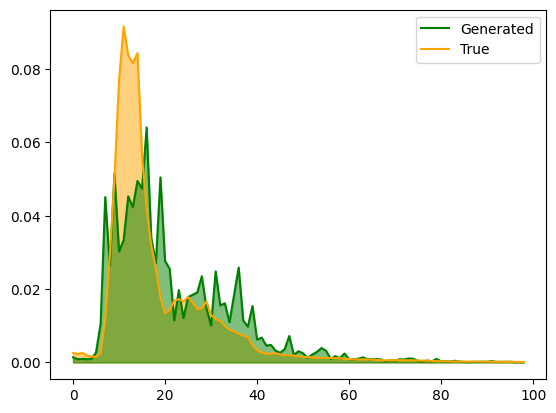

In [19]:
Eval.KLD_TrueGen(AnalSig=AnalData[:],  ) 